In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

from hydra import initialize, compose
import colorcet as cc
from matplotlib import font_manager
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib import colormaps
from matplotlib import colors
import numpy as np
import os
import pandas as pd
import scipy
from statsmodels.tsa.stattools import acf
import sys
from tqdm.auto import tqdm

from UniversalUnconsciousness.plot_utils import load_font

plt.style.use('UniversalUnconsciousness.sci_style')
load_font()

In [3]:
with initialize(version_base="1.3", config_path="../../UniversalUnconsciousness/DeLASE_analysis/conf"):
    cfg = compose(config_name="config")

In [4]:
img_save_dir = cfg.plotting.img_save_dir
curve_colors = cfg.plotting.curve_colors
loc_roc_colors = cfg.plotting.loc_roc_colors
os.makedirs(img_save_dir, exist_ok=True)

# Spring

In [11]:
def spring(t, x, M=10, k=1, R=10, I=0):
    if isinstance(I, np.ndarray):
        I = I[int(t/dt)]
    return [x[1], (-k*x[0] - R*x[1] + I)/M]
# see: https://faculty.washington.edu/seattle/physics227/reading/reading-3b.pdf

In [12]:
from scipy.integrate import solve_ivp

1.8811761111111112 1.312232777777778


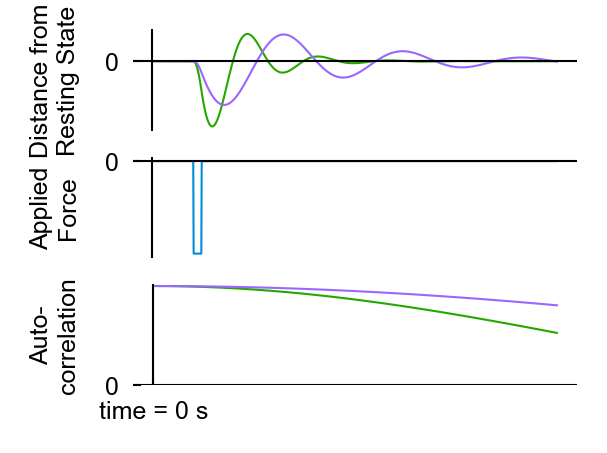

In [34]:
t_span = [0, 20]
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1], dt)
I = np.zeros(int(len(t_eval)*1.5))
I[100:120] = -10

sol = solve_ivp(lambda t, x: spring(t, x, k=70, M=5, I=I), y0=[0, 0], t_span=t_span, t_eval=t_eval)
x1 = sol.y.T
shift = 4
length = 1000

fig, axs = plt.subplots(3, 1, figsize=(1.9096, 1.5415))
plt.subplots_adjust(hspace=0.25)
ax = axs[0]
# ax.plot(np.arange(length) + shift, x[:length, 0], c='#f7931e', lw=6, alpha=1)
ax.plot(np.arange(length) + shift, x1[:length, 0], c='#24a800', alpha=1)
sol = solve_ivp(lambda t, x: spring(t, x, k=70, M=15, I=I), y0=[0, 0], t_span=t_span, t_eval=t_eval)
x2 = sol.y.T
ax.plot(np.arange(length) + shift, x2[:length, 0], c='#9966ff', alpha=1)
ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
# ax.set_xticks([0], ['time = 0 s'])
ax.set_xticks([])
ax.set_yticks([0], [0])
ax.axhline(0, c='k')
ax.axvline(0, c='k')

ax.set_ylabel('Distance from\nResting State', fontsize=6)

ax = axs[1]
ax.plot(np.arange(length) + shift, I[:length])

ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
# ax.set_xticks([0], ['time = 0 s'])
ax.set_xticks([])
ax.set_yticks([0])
ax.axhline(0, c='k')
ax.axvline(0, c='k')

ax.set_ylabel('Applied\nForce', fontsize=6)

bbox = fig.get_tightbbox(fig.canvas.get_renderer())
# Calculate width and height of the bounding box in inches
width_inches = (bbox.x1 - bbox.x0)
height_inches = (bbox.y1 - bbox.y0)
print(width_inches, height_inches)

autocorr_x1 = acf(x1[:length, 0], fft=True)
autocorr_x2 = acf(x2[:length, 0], fft=True)

ax = axs[2]
ax.plot(autocorr_x1, c='#24a800', alpha=1, label='x1 Autocorrelation')
ax.plot(autocorr_x2, c='#9966ff', alpha=1, label='x2 Autocorrelation')

ax.spines[['right', 'top', 'bottom', 'left']].set_visible(False)
ax.set_xticks([0], ['time = 0 s'])
ax.set_yticks([0])
ax.axhline(0, c='k')
ax.axvline(0, c='k')

ax.set_ylabel('Auto-\ncorrelation', fontsize=6)
# ax.legend()


plt.savefig(os.path.join(img_save_dir, "spring.pdf"), bbox_inches='tight', transparent=True, dpi=300)
plt.show()

## Linear Filter

In [5]:
def response_1D_filter(t,a, freq=1):
  return (a*np.sin(t*2*np.pi*freq) - np.cos(t*2*np.pi*freq))*(1/(a**2+1))

In [293]:
# Define the parameters
# N = int(1e5)
N = int(1e3)
T = 1.25
dt = T / N
x0 = 0.0
ts = np.linspace(0,T,N)
#lam = 1

# Define the Weiner process


def do_one_sde_run(lam,ts, random_seed=42):

  np.random.seed(random_seed)
  dW = np.sqrt(dt) * np.random.randn(N)

  # Define the function f(x)
  def f(x,lam):
      return -lam * x

  # Define the function g(x)
  def g(x):
      return 0.05

  # Initialize the x array
  x = np.zeros(N)
  x[0] = x0

  sine_on = 0

  # Simulate the stochastic differential equation
  for i,time in enumerate(ts):

      if (time >= 0.25 and time < 0.75):
        # sine_on = -1
        sine_on = 1
        freq = 2
      # elif (time >= 2 and time < 2.5):
      #   sine_on = -1
      #   freq = 2
      else:
        sine_on = 0
        freq = 1

      x[i] = x[i-1] + (f(x[i-1],lam) + sine_on*np.sin(2*np.pi*freq*time)) * dt + g(x[i-1]) * dW[i]

  return x

#try two different lambdas
lam_1, lam_2 = 200, 25
num_runs = 50
x_1 = np.zeros((num_runs, N))
x_2 = np.zeros((num_runs, N))
for i in range(num_runs):
  x_1[i] = do_one_sde_run(lam = lam_1,ts = ts, random_seed=i + 42)
  x_2[i] = do_one_sde_run(lam = lam_2,ts = ts, random_seed=i + 42)


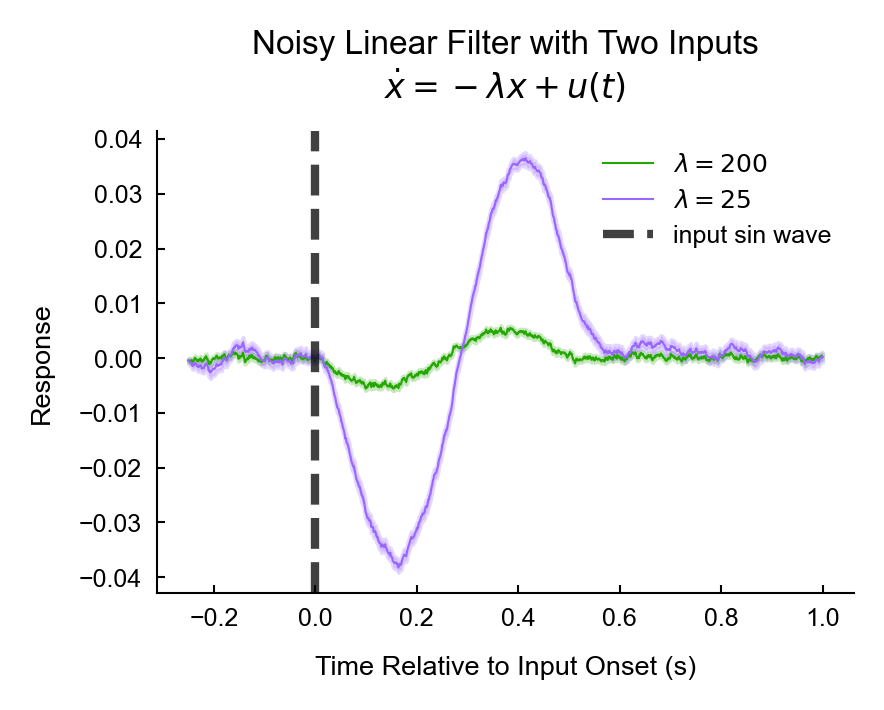

In [300]:

plt.figure(figsize=(3, 2))

# Plot the results
plt.plot(ts - 0.25, x_1.mean(axis=0), label = f'$\lambda = {lam_1}$', c='#24a800')
x_1_sem = x_1.std(axis=0) / np.sqrt(num_runs)
plt.fill_between(ts - 0.25, x_1.mean(axis=0) - x_1_sem, x_1.mean(axis=0) + x_1_sem, alpha=0.25, color='#24a800')
plt.plot(ts - 0.25, x_2.mean(axis=0), label = f'$\lambda = {lam_2}$', c='#9966ff')
x_2_sem = x_2.std(axis=0) / np.sqrt(num_runs)
plt.fill_between(ts - 0.25, x_2.mean(axis=0) - x_2_sem, x_2.mean(axis=0) + x_2_sem, alpha=0.25, color='#9966ff')

ax = plt.gca()
ax.spines[['right', 'top']].set_visible(False)
ax.xaxis.set_ticks_position('bottom')
ax.yaxis.set_ticks_position('left')

ax.axvline(0, c='k', lw=2, linestyle='--', label='input sin wave', alpha=0.75)
# ax.axvline(1, c='midnightblue', lw=2, linestyle='--', label='input 2', alpha=0.75)


plt.legend(fontsize=6)
plt.xlabel('Time Relative to Input Onset (s)')
plt.ylabel('Response')
plt.title('Noisy Linear Filter with Two Inputs\n$\dot{x} = -\lambda x + u(t)$')

plt.show()

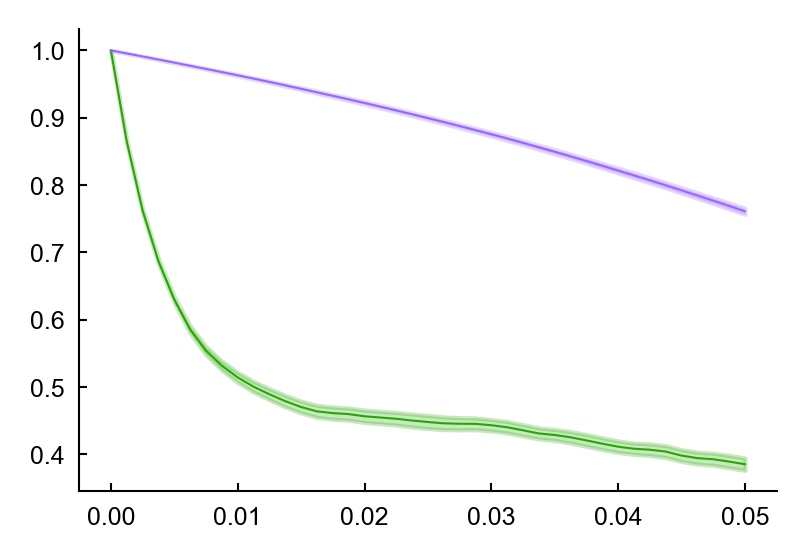

In [301]:
# compute autocorrelation of response
autocorr_x1 = np.zeros((num_runs, int(0.05/dt) + 1))
autocorr_x2 = np.zeros((num_runs, int(0.05/dt) + 1))
for i in range(num_runs):
  autocorr_x1[i] = acf(x_1[i][(ts - 0.25) >= 0], nlags=int(0.05/dt))
  autocorr_x2[i] = acf(x_2[i][(ts - 0.25) >= 0], nlags=int(0.05/dt))

plt.figure(figsize=(3, 2))
plt.plot(np.arange(autocorr_x1.shape[-1])*dt, autocorr_x1.mean(axis=0), c='#24a800', alpha=1, label='x1 Autocorrelation')
autocorr_x1_sem = autocorr_x1.std(axis=0) / np.sqrt(num_runs)
plt.fill_between(np.arange(autocorr_x1.shape[-1])*dt, autocorr_x1.mean(axis=0) - autocorr_x1_sem, autocorr_x1.mean(axis=0) + autocorr_x1_sem, alpha=0.25, color='#24a800')
plt.plot(np.arange(autocorr_x2.shape[-1])*dt, autocorr_x2.mean(axis=0), c='#9966ff', alpha=1, label='x2 Autocorrelation')
autocorr_x2_sem = autocorr_x2.std(axis=0) / np.sqrt(num_runs)
plt.fill_between(np.arange(autocorr_x2.shape[-1])*dt, autocorr_x2.mean(axis=0) - autocorr_x2_sem, autocorr_x2.mean(axis=0) + autocorr_x2_sem, alpha=0.25, color='#9966ff')
